# Aging Aware with Model Variation
Previously, we optimize the following functional:
$$ \min_\theta \, \int_{t=0}^{1} \; L(\theta(t)) \, {\rm d}t. $$
The optimum is for a specific aging model $\omega$, i.e., we minimized the 
$$ \min_\theta \, \int_{t=0}^{1} \; L(\theta(t,\omega)) \, {\rm d}t. $$
However, we dont know how will the resistance decay, i.e., we should also minimize the loss function w.r.t. aging models with different parameters. That means we need to optimized
$$ \min_\theta \, \int_{\omega}\int_{t=0}^{1} \; L(\theta(t,\omega)) \, {\rm d}t\, p(\omega){\rm d}\omega. $$
The Mento Carlo Approximation is then
$$
\min_{\theta_{\rm init}} \frac{1}{\Omega}\frac{1}{K}\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right),
$$
where $\mathfrak{M}$ is the set of $\Omega$ elements following the distribution $p(\omega)$. $p(\omega)$ is the distributions of parameters of the aging model. We have already obtained these distributions as we modeled the aging decay.

That means we should optimize this problem by
$$
\begin{align}
\theta_{\rm init}&:=\theta_{\rm init} - \alpha\cdot\nabla_{\theta_{\rm init}}\left(\frac{1}{\Omega}\frac{1}{K}\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right)\right)\\
&=\theta_{\rm init} - \frac{\alpha}{\Omega K}\cdot\nabla_{\theta_{\rm init}}\left(\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right)\right)\\
&=\theta_{\rm init} - \frac{\alpha}{\Omega K}\left(\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} }\nabla_{\theta_{\rm init}} L \left(\theta[k, \omega]\right)\right)
\end{align}
$$

# Get aging model

In [9]:
import importlib
from torch.autograd import Variable
import torch
import pickle
import pNN_aging_aware as pnn
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import training
import random
import PNN_Setting as ps
import config
sys.path.append(os.path.join(os.getcwd(), 'Aging_Model'))

with open(os.path.join(os.getcwd(), 'Aging_Model', 'exp_aging_model.p'), 'rb') as f:
    age_generator = pickle.load(f)

# Prepare data

## Load data

In [10]:
datapath = os.path.join(os.getcwd(), 'Datasets',
                        'dataset_processed', f'Dataset_Seeds.p')
with open(datapath, 'rb') as f:
    dataset = pickle.load(f)
X = dataset['X'].float()
y = dataset['y']

E, N_features, N_class = X.shape[0], X.shape[1], torch.max(
    torch.unique(y)).item()+1
X.shape, y.shape, E, N_features, N_class

(torch.Size([210, 7]), torch.Size([210]), 210, 7, 3)

## data preprocessing

In [11]:
# normalization
X = X / (torch.max(X, axis=0)[0] - torch.min(X, axis=0)[0])
X = X - torch.min(X, axis=0)[0]
torch.min(X), torch.max(X)

(tensor(0.), tensor(1.))

In [12]:
X[:10, :9]

tensor([[0.4410, 0.5021, 0.5708, 0.4865, 0.4861, 0.1893, 0.3452],
        [0.4051, 0.4463, 0.6624, 0.3688, 0.5011, 0.0329, 0.2152],
        [0.3494, 0.3471, 0.8793, 0.2207, 0.5039, 0.2515, 0.1507],
        [0.3069, 0.3161, 0.7931, 0.2393, 0.5339, 0.1942, 0.1408],
        [0.5241, 0.5331, 0.8648, 0.4274, 0.6643, 0.0767, 0.3230],
        [0.3579, 0.3719, 0.7895, 0.2742, 0.4861, 0.2206, 0.2152],
        [0.3872, 0.4298, 0.6515, 0.3739, 0.4483, 0.3668, 0.3447],
        [0.3324, 0.3492, 0.7532, 0.2934, 0.4790, 0.2516, 0.2368],
        [0.5704, 0.6302, 0.6044, 0.6498, 0.5952, 0.1658, 0.6686],
        [0.5524, 0.5868, 0.7250, 0.5546, 0.6237, 0.1565, 0.4993]])

In [13]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

# generate tensordataset
dataset = TensorDataset(X, y)

# split
train_rate = 0.6
valid_rate = 0.2
test_rate = 0.2
E_train = min(8192, int(E*train_rate))
E_valid = min(2048, int(E*valid_rate))
E_test = min(2048, int(E*test_rate))

random.seed(config.data_split_seed);
np.random.seed(config.data_split_seed);
torch.manual_seed(config.data_split_seed);

train_data, rest_data = random_split(dataset, [E_train, E-E_train])
valid_data, rest_data = random_split(rest_data, [E_valid, E-E_train-E_valid])
test_data, rest_data = random_split(rest_data, [E_test, E-E_train-E_valid-E_test])

len(train_data), len(valid_data), len(test_data)

(126, 42, 42)

In [14]:
# batch
train_loader = DataLoader(train_data, batch_size=len(train_data))
valid_loader = DataLoader(valid_data, batch_size=len(valid_data))
test_loader = DataLoader(test_data, batch_size=len(test_data))

# Hyperparameter

In [17]:
N_Hidden = 4
K = 5   # number of time sampling
M = 40  # number of model sampling
K_valid = 5
M_valid = 10

# Normal NN
## Training

In [18]:
NN = torch.nn.Sequential(torch.nn.Linear(N_features, N_Hidden), torch.nn.Tanh(),
                         torch.nn.Linear(N_Hidden, N_class), torch.nn.Tanh())


def weights_init(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)


NN.apply(weights_init)

optimizer_NN = torch.optim.Adam(NN.parameters(), lr=0.01)
celoss = torch.nn.CrossEntropyLoss()
NN

Sequential(
  (0): Linear(in_features=7, out_features=4, bias=True)
  (1): Tanh()
  (2): Linear(in_features=4, out_features=3, bias=True)
  (3): Tanh()
)

In [19]:
train_loss_NN, valid_loss_NN, parameter_NN = training.train_normal_nn(NN,
                                                                     train_loader,
                                                                     valid_loader,
                                                                     optimizer=optimizer_NN,
                                                                     lossfunction=celoss,
                                                                     Epoch=15000)

  0%|          | 0/15000 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.47619 | Loss: 1.066063404 |
| Epoch:   100 | Accuracy: 0.90476 | Loss: 0.474944025 |
| Epoch:   200 | Accuracy: 0.92857 | Loss: 0.405940861 |
| Epoch:   300 | Accuracy: 0.92857 | Loss: 0.369035780 |
| Epoch:   400 | Accuracy: 0.92857 | Loss: 0.346163601 |
| Epoch:   500 | Accuracy: 0.92857 | Loss: 0.333522260 |
| Epoch:   600 | Accuracy: 0.92857 | Loss: 0.326266676 |
| Epoch:   700 | Accuracy: 0.95238 | Loss: 0.321692020 |
| Epoch:   800 | Accuracy: 0.95238 | Loss: 0.318589747 |
| Epoch:   900 | Accuracy: 0.95238 | Loss: 0.316427201 |
| Epoch:  1000 | Accuracy: 0.95238 | Loss: 0.314910054 |
| Epoch:  1100 | Accuracy: 0.95238 | Loss: 0.313833296 |
| Epoch:  1200 | Accuracy: 0.95238 | Loss: 0.313046992 |
| Epoch:  1300 | Accuracy: 0.95238 | Loss: 0.312445194 |
| Epoch:  1400 | Accuracy: 0.95238 | Loss: 0.311955124 |
| Epoch:  1500 | Accuracy: 0.95238 | Loss: 0.311527163 |
| Epoch:  1600 | Accuracy: 0.95238 | Loss: 0.311126620 |
| Epoch:  1700 | Accuracy: 0.95

(2568, tensor(0.3025))

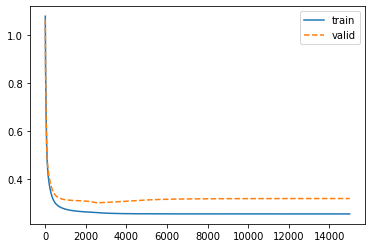

In [20]:
plt.plot(train_loss_NN, '-', label='train')
plt.plot(valid_loss_NN, '--', label='valid')
plt.legend()
best = np.argmin(valid_loss_NN)
best, valid_loss_NN[best]

## save model

In [24]:
# with open('./pendigitresult/NN_16.p', 'wb') as f:
#     pickle.dump(NN, f)

## load model

In [25]:
# with open('./pendigitresult/NN_16.p', 'rb') as f:
#     NN = pickle.load(f)

## evalutation

In [21]:
for x_test, y_test in test_loader:
    prediction_test = NN(x_test)
    p = torch.argmax(prediction_test, 1)
    pred_y = p.data.numpy().squeeze()
    acc_test = sum(pred_y == y_test.numpy()) / y_test.shape[0]
print(acc_test)

0.9523809523809523


# PNN
## Training

In [22]:
PNN = torch.nn.Sequential(pnn.PNNLayer(N_features, N_Hidden, age_generator),
                          pnn.PNNLayer(N_Hidden, N_class, age_generator))
optimizer_PNN = torch.optim.Adam(PNN.parameters(), lr=0.01)
PNN

Sequential(
  (0): PNNLayer()
  (1): PNNLayer()
)

In [23]:
train_loss_PNN, valid_loss_PNN, parameter_PNN = training.train_normal_pnn(
    PNN, train_loader, valid_loader, m, T, optimizer_PNN, pnn.LossFunction, 15000)

  0%|          | 0/15000 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.33333 | Loss: 1.192396433 |
| Epoch:   100 | Accuracy: 0.88095 | Loss: 0.261180320 |
| Epoch:   200 | Accuracy: 0.88095 | Loss: 0.159867128 |
| Epoch:   300 | Accuracy: 0.92857 | Loss: 0.140305372 |
| Epoch:   400 | Accuracy: 0.95238 | Loss: 0.128043109 |
| Epoch:   500 | Accuracy: 0.95238 | Loss: 0.118733983 |
| Epoch:   600 | Accuracy: 0.95238 | Loss: 0.114248050 |
| Epoch:   700 | Accuracy: 0.95238 | Loss: 0.112576655 |
| Epoch:   800 | Accuracy: 0.95238 | Loss: 0.109077277 |
| Epoch:   900 | Accuracy: 0.95238 | Loss: 0.104235057 |
| Epoch:  1000 | Accuracy: 0.95238 | Loss: 0.101752212 |
| Epoch:  1100 | Accuracy: 0.95238 | Loss: 0.103371457 |
| Epoch:  1200 | Accuracy: 0.95238 | Loss: 0.104335853 |
| Epoch:  1300 | Accuracy: 0.95238 | Loss: 0.106039298 |
| Epoch:  1400 | Accuracy: 0.95238 | Loss: 0.107889915 |
| Epoch:  1500 | Accuracy: 0.95238 | Loss: 0.108985582 |
| Epoch:  1600 | Accuracy: 0.95238 | Loss: 0.110562002 |
| Epoch:  1700 | Accuracy: 0.95

(6783, tensor(0.0670, dtype=torch.float64))

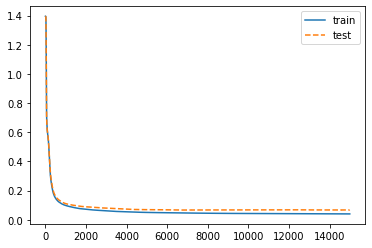

In [11]:
plt.plot(train_loss_PNN, '-', label='train')
plt.plot(valid_loss_PNN, '--', label='valid')
plt.legend()
best = np.argmin(valid_loss_PNN)
PNN.load_state_dict(parameter_PNN)
best, valid_loss_PNN[best]

## save PNN

In [12]:
# with open('./pendigitresult/PNN_16.p', 'wb') as f:
#     pickle.dump(PNN, f)

## load PNN

In [13]:
# with open('./pendigitresult/PNN_16.p', 'rb') as f:
#     PNN = pickle.load(f)

## Functions for setting times and models

In [24]:
import PNN_Setting as ps
# ps.makemodel
# ps.settime
# ps.zerogradient

Usage of functions: 

`pnn.apply(lambda z: settime(z, time))`

`pnn.apply(makemodel)`

`pnn.apply(zerogradient)`

## evaluation

In [25]:
import evaluation
importlib.reload(evaluation)
mean_acc_PNN, std_acc_PNN, mean_maa_PNN, std_maa_PNN = evaluation.FullEvaluation(PNN, test_loader)

  0%|          | 0/500 [00:00<?, ?it/s]

evaluating on the 0-th model.
evaluating on the 10-th model.
evaluating on the 20-th model.
evaluating on the 30-th model.
evaluating on the 40-th model.
evaluating on the 50-th model.
evaluating on the 60-th model.
evaluating on the 70-th model.
evaluating on the 80-th model.
evaluating on the 90-th model.
evaluating on the 100-th model.
evaluating on the 110-th model.
evaluating on the 120-th model.
evaluating on the 130-th model.
evaluating on the 140-th model.
evaluating on the 150-th model.
evaluating on the 160-th model.
evaluating on the 170-th model.
evaluating on the 180-th model.
evaluating on the 190-th model.
evaluating on the 200-th model.
evaluating on the 210-th model.
evaluating on the 220-th model.
evaluating on the 230-th model.
evaluating on the 240-th model.
evaluating on the 250-th model.
evaluating on the 260-th model.
evaluating on the 270-th model.
evaluating on the 280-th model.
evaluating on the 290-th model.
evaluating on the 300-th model.
evaluating on the 3

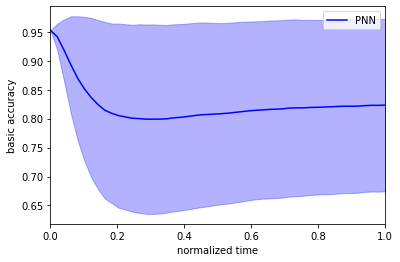

In [26]:
plt.fill_between(np.linspace(0,1,50), mean_acc_PNN-std_acc_PNN, mean_acc_PNN+std_acc_PNN, alpha=0.3, color='blue');
plt.plot(np.linspace(0,1,50), mean_acc_PNN, label='PNN', color='blue');

plt.xlabel('normalized time');
plt.ylabel('basic accuracy');
plt.xlim([0, 1]);
plt.legend();

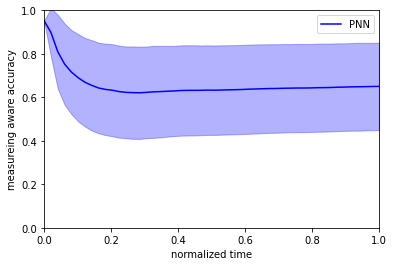

In [27]:
plt.fill_between(np.linspace(0,1,50), mean_maa_PNN-std_maa_PNN, mean_maa_PNN+std_maa_PNN, alpha=0.3, color='blue');
plt.plot(np.linspace(0,1,50), mean_maa_PNN, label='PNN', color='blue');

plt.xlabel('normalized time');
plt.ylabel('measureing aware accuracy');
plt.xlim([0, 1]);
plt.ylim([0, 1]);
plt.legend();

# Aging Aware PNN
## Training

In [28]:
AAPNN = torch.nn.Sequential(pnn.PNNLayer(N_features, N_Hidden, age_generator),
                            pnn.PNNLayer(N_Hidden, N_class, age_generator))

optimizer_AAPNN = torch.optim.Adam(AAPNN.parameters(), lr=0.5)
AAPNN

Sequential(
  (0): PNNLayer()
  (1): PNNLayer()
)

### Functions for generating parallel AAPNNs

In [9]:
# ps.MakeParallelPNNs
# ps.MakeParallelModels

Usage:

`Parallel_PNNs = ps.MakeParallelPNNs(pnn, M, K)`, generating different models & different time stamps

`Parallel_PNNs = ps.MakeParallelPNNs(pnn, M)`, generating only different models

# Load temp parameter when corrupt

In [10]:
# with open('./temp/AAPNN.p', 'rb') as f:
    # AAPNN = pickle.load(f)

## Parallel Training

In [29]:
importlib.reload(training)
valid_loss_AAPNN, parameter_AAPNN = training.ParallelTrainingAAPNN(AAPNN,
                                                                  train_loader, valid_loader,
                                                                  optimizer_AAPNN,
                                                                  pnn.LossFunction, m, T,
                                                                  M, K, M_valid, K_valid, Epoch=700)

  0%|          | 0/700 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.33333 | Loss: 0.893213504 |
| Epoch:    10 | Accuracy: 0.74714 | Loss: 0.489570548 |
| Epoch:    20 | Accuracy: 0.85905 | Loss: 0.287268056 |
| Epoch:    30 | Accuracy: 0.86381 | Loss: 0.268375703 |
| Epoch:    40 | Accuracy: 0.87000 | Loss: 0.244245548 |
| Epoch:    50 | Accuracy: 0.86667 | Loss: 0.246072586 |
| Epoch:    60 | Accuracy: 0.86381 | Loss: 0.274838193 |
| Epoch:    70 | Accuracy: 0.87667 | Loss: 0.239578016 |
| Epoch:    80 | Accuracy: 0.87714 | Loss: 0.235440141 |
| Epoch:    90 | Accuracy: 0.87143 | Loss: 0.254232472 |
| Epoch:   100 | Accuracy: 0.88857 | Loss: 0.208252482 |
| Epoch:   110 | Accuracy: 0.87857 | Loss: 0.221013627 |
| Epoch:   120 | Accuracy: 0.89619 | Loss: 0.205273342 |
| Epoch:   130 | Accuracy: 0.90000 | Loss: 0.193638848 |
| Epoch:   140 | Accuracy: 0.88762 | Loss: 0.207528532 |
| Epoch:   150 | Accuracy: 0.88190 | Loss: 0.227364999 |
| Epoch:   160 | Accuracy: 0.88286 | Loss: 0.199187963 |
| Epoch:   170 | Accuracy: 0.90

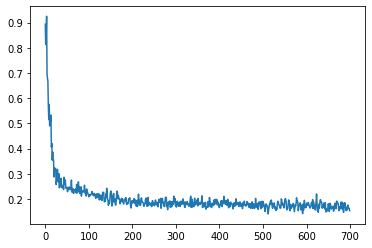

In [30]:
plt.plot(valid_loss_AAPNN);
AAPNN.load_state_dict(parameter_AAPNN);

## save AAPNN

In [12]:
# with open('./pendigitresult/AAPNN_16.p', 'wb') as f:
#     pickle.dump(AAPNN, f)

## read AAPNN

In [13]:
# with open('./pendigitresult/AAPNN_16.p', 'rb') as f:
#     AAPNN = pickle.load(f)

## Evaluation

In [31]:
import evaluation
mean_acc_AAPNN, std_acc_AAPNN, mean_maa_AAPNN, std_maa_AAPNN = evaluation.FullEvaluation(AAPNN, test_loader)

  0%|          | 0/500 [00:00<?, ?it/s]

evaluating on the 0-th model.
evaluating on the 10-th model.
evaluating on the 20-th model.
evaluating on the 30-th model.
evaluating on the 40-th model.
evaluating on the 50-th model.
evaluating on the 60-th model.
evaluating on the 70-th model.
evaluating on the 80-th model.
evaluating on the 90-th model.
evaluating on the 100-th model.
evaluating on the 110-th model.
evaluating on the 120-th model.
evaluating on the 130-th model.
evaluating on the 140-th model.
evaluating on the 150-th model.
evaluating on the 160-th model.
evaluating on the 170-th model.
evaluating on the 180-th model.
evaluating on the 190-th model.
evaluating on the 200-th model.
evaluating on the 210-th model.
evaluating on the 220-th model.
evaluating on the 230-th model.
evaluating on the 240-th model.
evaluating on the 250-th model.
evaluating on the 260-th model.
evaluating on the 270-th model.
evaluating on the 280-th model.
evaluating on the 290-th model.
evaluating on the 300-th model.
evaluating on the 3

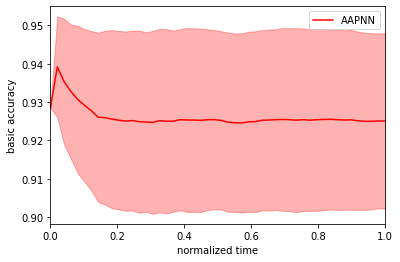

In [32]:
plt.fill_between(np.linspace(0,1,50), mean_acc_AAPNN-std_acc_AAPNN, mean_acc_AAPNN+std_acc_AAPNN, alpha=0.3, color='red');
plt.plot(np.linspace(0,1,50), mean_acc_AAPNN, label='AAPNN', color='red');

plt.xlabel('normalized time');
plt.ylabel('basic accuracy');
plt.xlim([0, 1]);
plt.legend();

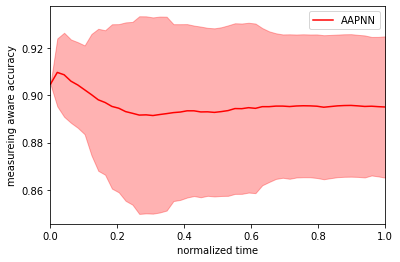

In [34]:
plt.fill_between(np.linspace(0,1,50), mean_maa_AAPNN-std_maa_AAPNN, mean_maa_AAPNN+std_maa_AAPNN, alpha=0.3, color='red');
plt.plot(np.linspace(0,1,50), mean_maa_AAPNN, label='AAPNN', color='red');

plt.xlabel('normalized time');
plt.ylabel('measureing aware accuracy');
plt.xlim([0, 1]);
plt.legend();